# ESTIMATING SIGNAL SIGNIFICANCE

Based on the 2019 LIGO Open Data Workshop

When dealing with real gravitational wave signals, we want to be sure we are reporting actual astrophysical events, and not confusing our detections with some sort of noise transient present in our detectors. 

At the end of this notebook there is an extension challenge that investigates estimating the significance of some real GW signals that LIGO/Virgo/KAGRA has detected.

This notebook uses a new data processing package called gwpy. gwpy is really useful for interacting directly with real GW data. If you are running this on COLAB, or on your own machine, uncomment the next line to install gwpy

In [1]:
# !pip install gwpy

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import tukey

import gwpy.timeseries
# CAUTION: make sure you don't mix up the gwpy TimeSeries function, and the PyCBC one! I don't 
# recommend directly importing them for this reason

import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pycbc.types

Let's start by looking at a nice bright GW event: GW200311_115853. If we know the event name, gwpy gives us everything we need to directly interact with the real detector data that is publically available. You can find out more about public data access to calibrated LVK data on the [Gravitational Wave Open Science Center](www.gw-openscience.org/). 

If you are not a member of the LVK, there is a lot of data you can access using the ```fetch_open_data``` function. But, it requires us to know the time at which an event occured. We can look this up on GWOSC - for GW200129_065458, I've hard-coded the event time below, but you can explore any events using the event API

In [100]:
event_time = 1267963151.3

# data_L1 = gwpy.timeseries.TimeSeries.fetch_open_data('L1', event_time - 30, event_time + 10)
# data_H1 = gwpy.timeseries.TimeSeries.fetch_open_data('H1', event_time - 30, event_time + 10)
# data_V1 = gwpy.timeseries.TimeSeries.fetch_open_data('V1', event_time - 30, event_time + 10)

One thing to note about events is that not all detectors have data for all events - they may have not been online at the time, or for some reason the data is vetoed (i.e. the interferometer has a known problem). This is a common source of errors people run into when interacting with public data. 

We can now interact with this data exactly as we would with our imported PyCBC timeseries in the previous exercise - we condition it in exactly the same way

In [101]:
# condition and get PSD for each detector: 
ifos = ['H1', 'L1', 'V1']
data = {}
conditioned_data = {}
psd = {}

for ifo in ifos:
    data[ifo] = gwpy.timeseries.TimeSeries.fetch_open_data(ifo, event_time - 30, event_time + 30)

    data[ifo] = data[ifo].to_pycbc() # need to convert first to a PyCBC timeseries
    data_highpass = pycbc.filter.highpass(data[ifo], 20.0)
    tukey_rolloff = 3.0 # number of seconds to taper by 
    window = tukey(len(data_highpass), tukey_rolloff / (max(data_highpass.sample_times) \
                                                                - min(data_highpass.sample_times)))
    conditioned_data[ifo] = window * data_highpass


    # PSD estimation
    segment_length_seconds = 4
    # needs to be provided in terms of samples!
    seg_len = int(segment_length_seconds / conditioned_data[ifo].delta_t)
    # How much to overlap by
    seg_stride = int(seg_len / 2)

    estimated_psd = pycbc.psd.welch(conditioned_data[ifo],
                          seg_len=seg_len,
                          seg_stride=seg_stride)
    estimated_psd = pycbc.psd.interpolate(estimated_psd , conditioned_data[ifo].delta_f)
    psd[ifo] = pycbc.psd.inverse_spectrum_truncation(estimated_psd,
                                    int(4 * conditioned_data[ifo].sample_rate),
                                      low_frequency_cutoff=20.)

We can now create a filter to compute the SNR of our signal. We can again look on GWOSC to see what the masses of the black holes were for this signal (hint: scroll down to 'GWTC-3 PE')

In [102]:
# PE provides masses in the source frame - we actually detect things in the detector frame so 
# we need to correct for the difference in redshift. However in this case the source is pretty nearby, 
# so the correction is too small to care
mass1 = 34.2
mass2 = 27.7

hp, _ = pycbc.waveform.get_td_waveform(approximant="IMRPhenomD", mass1=mass1, mass2=mass2,
                         f_lower=15.0, 
                        delta_t=conditioned_data[ifo].delta_t)


# remember we need to resize it to the length of our timeseries
hp.resize(len(conditioned_data[ifo]))
template = hp.cyclic_time_shift(hp.start_time)

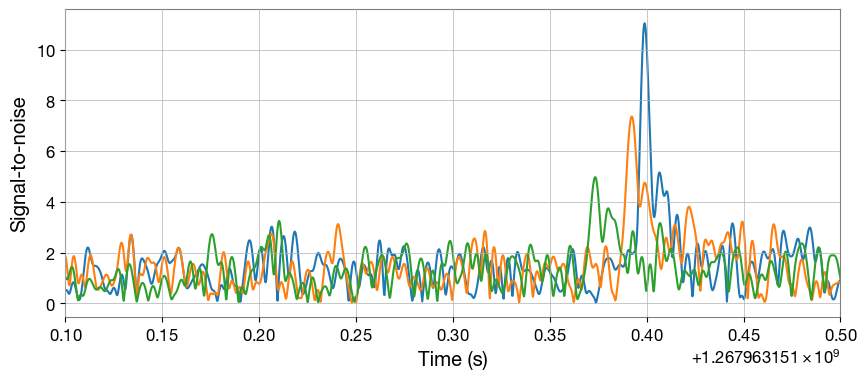

In [114]:
snrs = {}
for ifo in ifos: 
    snrs[ifo] = pycbc.filter.matched_filter(template, conditioned_data[ifo],
                     psd=psd[ifo], low_frequency_cutoff=30.0)

    snrs[ifo] = snrs[ifo].crop(2 + 2, 2)

plt.figure(figsize=[10, 4])
for ifo in ifos:
    plt.plot(snrs[ifo].sample_times, abs(snrs[ifo]))
plt.xlim(event_time - 0.2, event_time + 0.2)
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

Here you can see that there is almost certainly a signal present in Hanford and Livingston, but the Virgo peak barely clears the SNR = 4 threshold for 'signal-like' triggers

However, if we do zoom out (change the xlims in the plot above) you can see that there are some other quite high
SNR values at earlier times. So how do we know this isn't just another random blip of noise in Virgo?

We can attempt to crudely estimate the significance of our Virgo signal using a very simple method of 'time-slides'. This method is very similar to that used to estimate the properties of the background noise in searches run by PyCBC-Live (the PyCBC-Live version is a little more sophicsticated but operates on the same premise)

We will do this first by determining where one might expect a peak relative to the LIGO observed peaks. This is set by the constraint that an astrophysical source can only cause delays between observatories no larger than the light travel time between them. The ```pycbc.detector.Detector``` class provides some convenient methods to ask these sorts of questions.

We will then calculate the peak in the SNR for this window around the LIGO observed peaks. This is our "on-source".

Finally, to determine the significance of the on-source we will compare how likely it is for a peak as large or larger to appear in the background. Our background will be empirically measured by taking portions of the SNR time series from the "off-source" i.e. times that do not overlap the on-source. An important criteria to avoid a biased significance estimate is that the background and experiment be performed in the same manner.

In [115]:
from pycbc.detector import Detector

# Calculate the time of flight between the Virgo detectors and each LIGO observatory
d = Detector("V1")
tof = {}
tof['H1'] = d.light_travel_time_to_detector(Detector("H1"))
tof['L1'] = d.light_travel_time_to_detector(Detector("L1"))

# Record the time of the peak in the LIGO observatories
ptime = {}
for ifo in ifos:
    if ifo != 'V1':
        ptime[ifo] = snrs[ifo].sample_times[np.argmax(snrs[ifo])]

print(ptime)
    
# Calculate the span of time that a Virgo peak could in principle happen in from time of flight
# considerations.
start = ptime['H1'] - tof['H1']
end = ptime['L1'] + tof['L1']
# convert the times to indices along with how large the region is in number of samples
window_size = int((end - start) * snrs['V1'].sample_rate)
sidx = int((start - snrs['V1'].start_time) * snrs['V1'].sample_rate)
eidx = sidx + window_size

# Calculate the "on-source" peak SNR statistic value.
onsource = np.abs(snrs['V1'][sidx:eidx]).max()
print('Peak SNR found in on-source window for V1 is {}'.format(onsource))

{'H1': 1267963151.3967285, 'L1': 1267963151.3928223}
Peak SNR found in on-source window for V1 is 4.9703359298110135


In [116]:
# Now that we've calculated the onsource peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our
# onsource and repeating the same peak finding (max) procedure.

# Walk through the data in chunks and calculate the peak statistic value in each.
peaks = []
i = 0
while i + window_size < len(snrs['V1']):
    p = np.abs(snrs['V1'][i:i+window_size]).max()
    peaks.append(p)
    i += window_size
    
    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2
    
peaks = np.array(peaks)

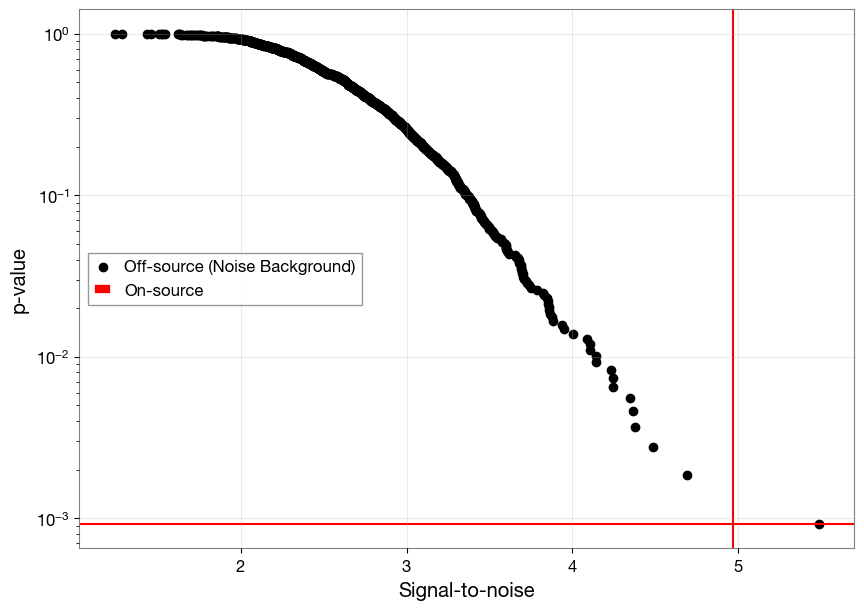

The p-value associated with the Virgo GW200311_115853 peak is 0.0009242144177449168


In [120]:
# The p-value is just the number of samples observed in the background with a 
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve = np.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource).sum() / float(len(peaks))

plt.figure(figsize=[10, 7])
plt.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

plt.axvline(onsource, label='On-source', color='red')
plt.axhline(pvalue, color='red')

plt.legend()
plt.yscale('log')
plt.grid('k', alpha = 0.4)
plt.ylabel('p-value')
plt.xlabel('Signal-to-noise')
plt.show()

print("The p-value associated with the Virgo GW200311_115853 peak is {}".format(pvalue))



So even though the SNR in Virgo is only just above the threshold, that peak is actually quite significant! 

# CHALLENGE QUESTION

Can you estimate the significance of the signal found in Virgo at the same time [GW190425](https://www.gw-openscience.org/eventapi/html/GWTC-2.1-confident/GW190425/v3) was detected in Livingston?

Some notes:
    - This was a BNS signal - you will need a longer stretch of data than for the BBH signals when you download it
    - The Hanford detector was offline at the time this signal was observed
    - This signal was observed online in one detector only, but subsequently found 'offline' in both L1 and V1